In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from clickhouse_driver import Client

client = Client(host='oleg.orbita.work',port=9000,user='student_ml',password='CGRV8zemLGgsfdz7Uc6ZJeisGTcPQa',settings={'use_numpy': True})
data = pd.DataFrame(client.execute("SELECT * FROM students_datas.weather_history"), columns=[
    'idx', 'year', 'month', 'day', 'min_t', 'average_t', 'max_t', 'rainfall'])
client.disconnect()
data.head()


,idx,year,month,day,min_t,average_t,max_t,rainfall
0,29838,1960,1,1,-6.9,-5.4,-3.8,0.1
1,29838,1960,1,2,-14.4,-10.0,-6.7,0.5
2,29838,1960,1,3,-21.7,-19.7,-13.4,0.0
3,29838,1960,1,4,-24.9,-21.4,-16.9,0.0
4,29838,1960,1,5,-18.3,-8.0,-3.3,4.1


#### 2. Удалите столбец idx

In [110]:

data.drop('idx', axis=1, inplace=True)
data.head()


,year,month,day,min_t,average_t,max_t,rainfall
0,1960,1,1,-6.9,-5.4,-3.8,0.1
1,1960,1,2,-14.4,-10.0,-6.7,0.5
2,1960,1,3,-21.7,-19.7,-13.4,0.0
3,1960,1,4,-24.9,-21.4,-16.9,0.0
4,1960,1,5,-18.3,-8.0,-3.3,4.1


#### 3. Используя метод info(), oтветьте на вопросы:

In [111]:
print("Информация о данных")
data.info()

Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22281 entries, 0 to 22280
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       22281 non-null  int64 
 1   month      22281 non-null  int64 
 2   day        22281 non-null  int64 
 3   min_t      22052 non-null  object
 4   average_t  22062 non-null  object
 5   max_t      22070 non-null  object
 6   rainfall   22051 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.2+ MB


#### 3.1.  Есть ли в данных пропущенные значения?

In [112]:
missing_values = data.isnull().sum()
missing_values

year           0
month          0
day            0
min_t        229
average_t    219
max_t        211
rainfall     230
dtype: int64

Да, пропущенные значения есть.

#### 3.2. В каком столбце данных больше всего пропущенных значений?

In [113]:
max_missing_column_name = missing_values.idxmax()
print(f"{max_missing_column_name}: {missing_values[max_missing_column_name]} пропущенных значений")

rainfall: 230 пропущенных значений


#### 4. В данных за какой год больше всего пропусков?

In [114]:
data_without_year = data.drop('year', axis=1)
data['missing_count'] = data_without_year.isnull().sum(axis=1)

missing_by_year = data.groupby('year')['missing_count'].sum()
max_missing_year = missing_by_year.idxmax()
max_missing_count = missing_by_year[max_missing_year]

print(f"В {max_missing_year} году {max_missing_count} пропуск")

В 1986 году 21 пропуск


#### 5. Объедините столбцы «Год», «Месяц» и «День» в один столбец «Дата» в формате гггг-мм-дд (2000-01-20). Данные в новом cтолбце должны иметь формат datetime;


In [115]:
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day']])
print(data.head())


   year  month  day  min_t average_t  max_t rainfall  missing_count   datetime
0  1960      1    1   -6.9      -5.4   -3.8      0.1              0 1960-01-01
1  1960      1    2  -14.4     -10.0   -6.7      0.5              0 1960-01-02
2  1960      1    3  -21.7     -19.7  -13.4      0.0              0 1960-01-03
3  1960      1    4  -24.9     -21.4  -16.9      0.0              0 1960-01-04
4  1960      1    5  -18.3      -8.0   -3.3      4.1              0 1960-01-05


#### 6. Для каждого наблюдения рассчитайте размах температур (разность максимальной и минимальной суточных температур) и количество предшествующих ему дней без осадков (используйте циклы Python и условный оператор):


In [116]:
data['min_t'] = pd.to_numeric(data['min_t'], errors='coerce')
data['max_t'] = pd.to_numeric(data['max_t'], errors='coerce')
data['average_t'] = pd.to_numeric(data['average_t'], errors='coerce')
data['rainfall'] = pd.to_numeric(data['rainfall'], errors='coerce')

data['temp_range'] = data['max_t'] - data['min_t']
print("Столбец с разностью максимальной и минимальной температур:")
print(data['temp_range'].head())

data['dry_days'] = 0
for i in range(1, len(data)):
    if data.loc[i, 'rainfall'] == 0:
        data.loc[i, 'dry_days'] = data.loc[i-1, 'dry_days'] + 1

print("\nСтолбец с расчетом дней без осадков:")
data['dry_days'].head()


Столбец с разностью максимальной и минимальной температур:
0     3.1
1     7.7
2     8.3
3     8.0
4    15.0
Name: temp_range, dtype: float64

Столбец с расчетом дней без осадков:


0    0
1    0
2    1
3    2
4    0
Name: dry_days, dtype: int64

#### 7. Определите самый длинный период засухи.

In [117]:
max_dry = data['dry_days'].max()
print(f"Самый длинный период засухи: {max_dry} дней")

Самый длинный период засухи: 27 дней


#### 8. Для каждого года вычислите среднегодовую температуру и общее количество осадков. Запишите результаты в объекты Series

In [118]:
year_avg_temp = data.groupby('year')['average_t'].mean()
print(f"Переменная year_avg_temp является объектом типа: {type(year_avg_temp)}")
year_total_rainfall = data.groupby('year')['rainfall'].sum()
print(f"Переменная year_total_rainfall является объектом типа: {type(year_total_rainfall)}")

print("Среднегодовая температура:")
print(year_avg_temp.head())
print("Общее кол-во осадков по годам:")
print(year_total_rainfall.head())


Переменная year_avg_temp является объектом типа: <class 'pandas.core.series.Series'>
Переменная year_total_rainfall является объектом типа: <class 'pandas.core.series.Series'>
Среднегодовая температура:
year
1960   -0.122740
1961    2.351524
1962    3.173130
1963    3.522626
1964    2.291160
Name: average_t, dtype: float64
Общее кол-во осадков по годам:
year
1960    458.7
1961    517.4
1962    367.5
1963    430.3
1964    424.4
Name: rainfall, dtype: float64


#### 8.1. Какой год можно считать самым теплым? Какой самым холодным?

Самый теплый год: 2020 
Средняя температура в теплом году: 4.8
Самый холодный год: 1969 
Средняя температура в холодном году: -0.6


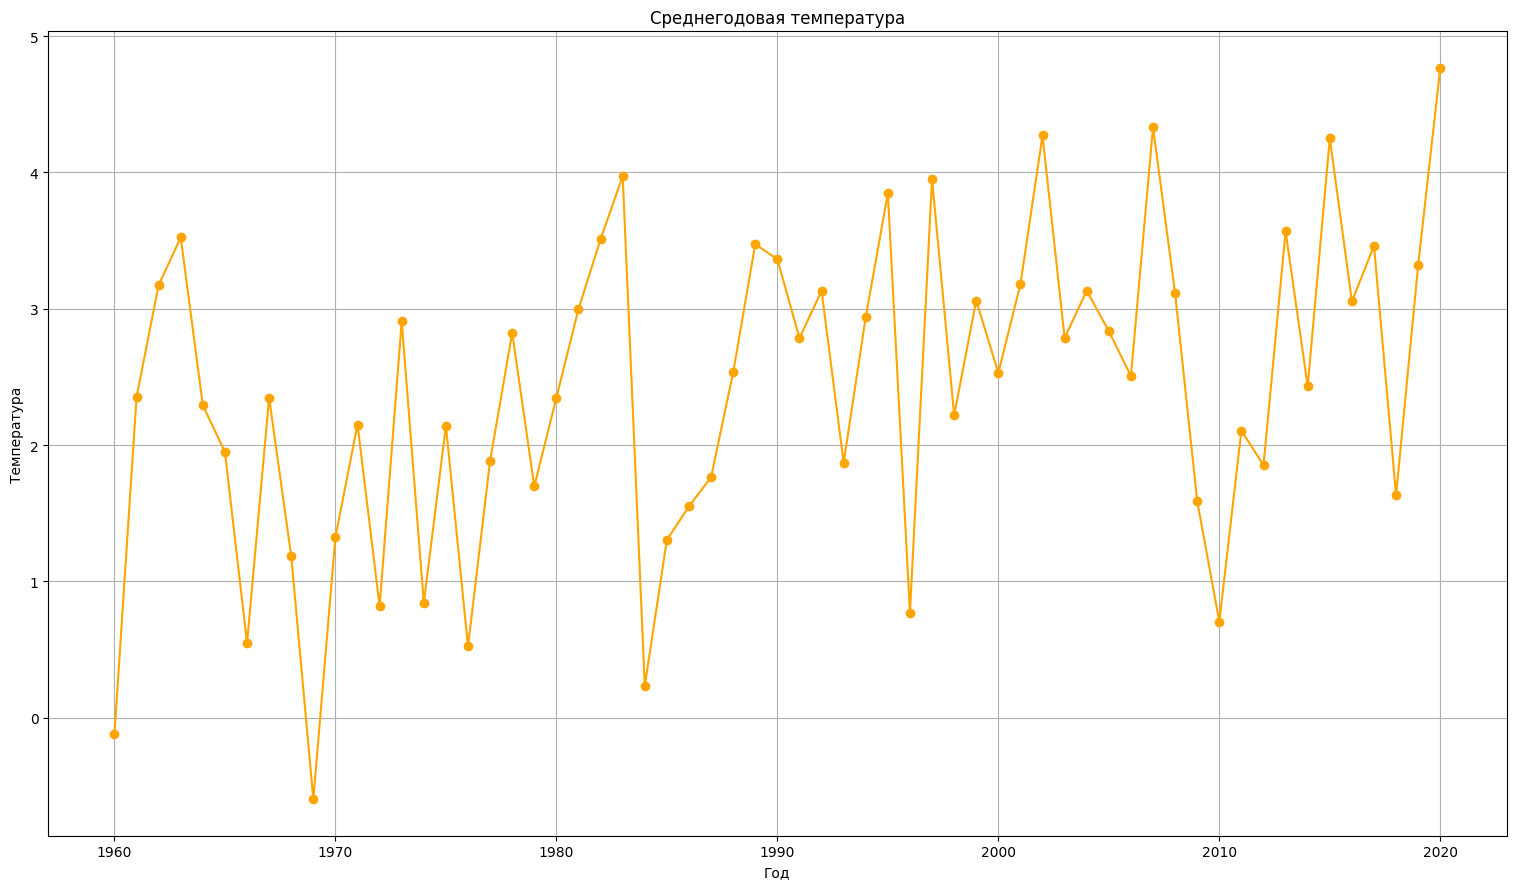

In [119]:
heat_year = year_avg_temp.idxmax()
cold_year = year_avg_temp.idxmin()
print(f"Самый теплый год: {heat_year} \nСредняя температура в теплом году: {year_avg_temp[heat_year]:.1f}")
print(f"Самый холодный год: {cold_year} \nСредняя температура в холодном году: {year_avg_temp[cold_year]:.1f}")

plt.figure(figsize=(30, 9))

plt.subplot(1, 2, 1)
year_avg_temp.plot(title='Среднегодовая температура', marker='o', color='orange')
plt.xlabel('Год')
plt.ylabel('Температура')
plt.grid(True)

plt.tight_layout()
plt.show()


#### 8.2. В какой год выпало больше всего осадков? В какой меньше всего? Используя запись имя_серии.plot() вы можете построить график и посмотреть как изменялась температура. С помощью имя_серии. .plot.bar() можно отобразить на столбиковой диаграмме количество осадков, выпавших в каждый год

Год с наибольшими осадками: 1970 - 560.2
Год с наименьшими осадками: 1973 - 258.0


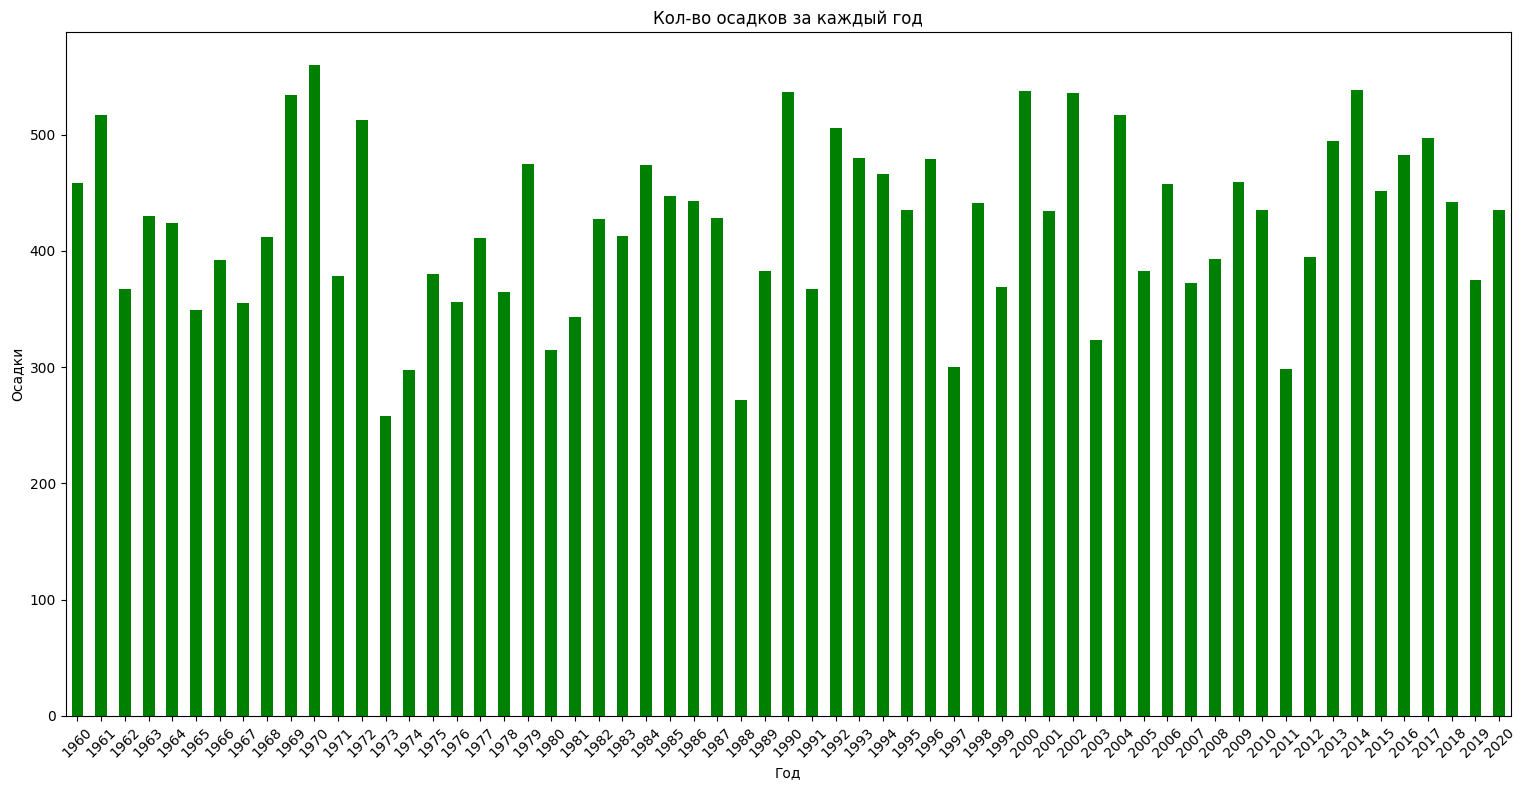

In [120]:
wettest_year = year_total_rainfall.idxmax()
driest_year = year_total_rainfall.idxmin()
print(f"Год с наибольшими осадками: {wettest_year} - {year_total_rainfall[wettest_year]:.1f}")
print(f"Год с наименьшими осадками: {driest_year} - {year_total_rainfall[driest_year]:.1f}")

plt.figure(figsize=(30, 8))

plt.subplot(1, 2, 2)
year_total_rainfall.plot.bar(title='Кол-во осадков за каждый год', color='green')
plt.xlabel('Год')
plt.ylabel('Осадки')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 9.1. Средняя температура воздуха ниже -30.

In [121]:
cold_days = data[data['average_t'] < -30]

cold_days[['datetime', 'average_t']]


,datetime,average_t
17,1960-01-18,-31.2
18,1960-01-19,-33.2
323,1960-11-19,-30.1
361,1960-12-27,-30.2
373,1961-01-08,-34.5
...,...,...
21585,2019-02-05,-32.0
21588,2019-02-08,-32.8
22275,2020-12-26,-31.6
22276,2020-12-27,-36.3


#### 9.2.Средняя температура воздуха выше 27 и количество дней без осадков больше 3.

In [122]:
hot_dry_days = data[(data['average_t'] > 27) & (data['dry_days'] > 3)]
hot_dry_days[['datetime', 'average_t', 'dry_days']]

,datetime,average_t,dry_days
1270,1963-06-24,27.4,9
2029,1965-07-22,27.3,10
3471,1969-07-03,27.1,5
3472,1969-07-04,28.9,6
3473,1969-07-05,27.9,7
5305,1974-07-11,27.8,19
6381,1977-06-21,27.2,25
8601,1983-07-20,27.2,7
10395,1988-06-17,28.3,7
11884,1992-07-15,28.0,7
